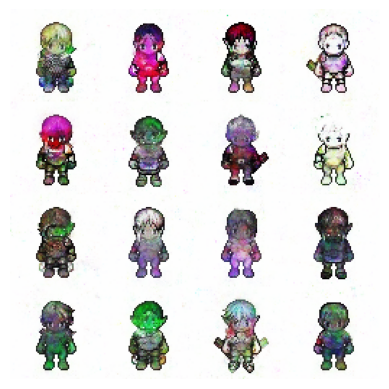

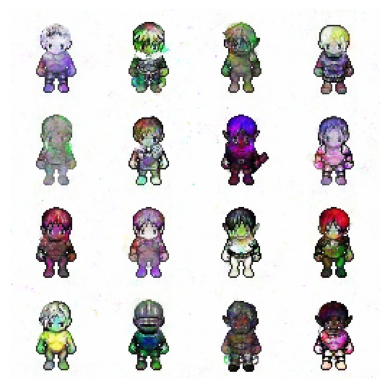

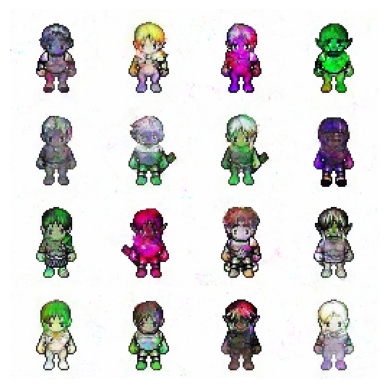

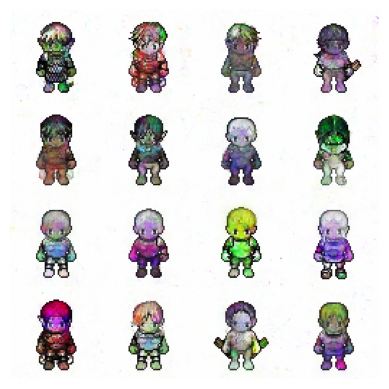

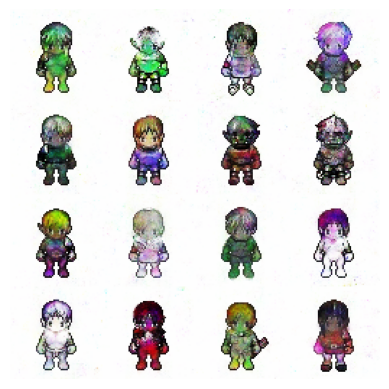

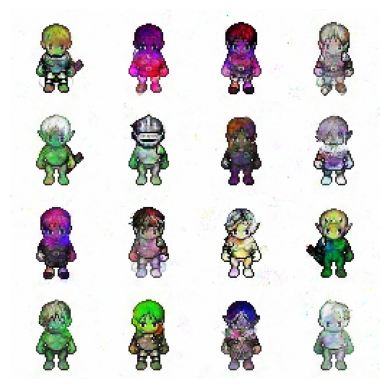

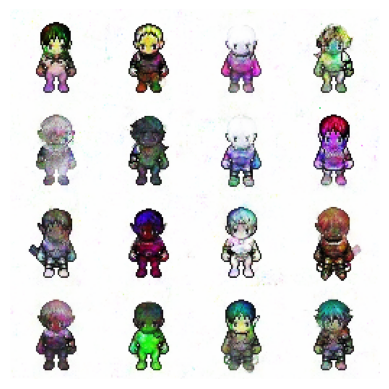

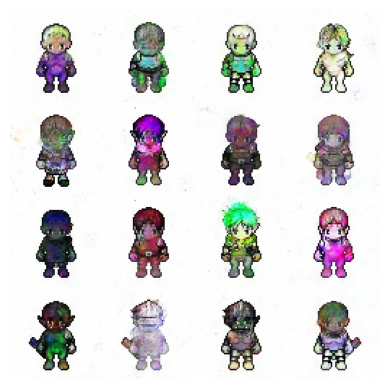

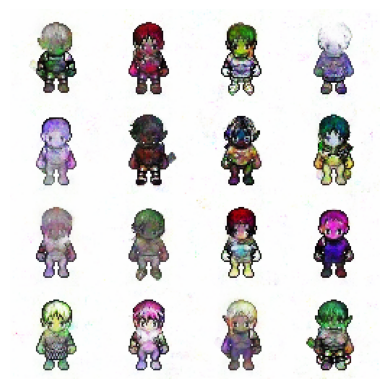

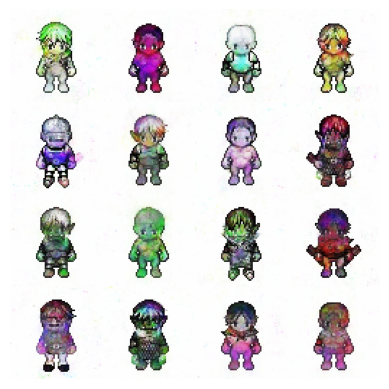

In [9]:
import numpy as np

# for image/model saves.
from PIL import Image
import pickle


LATENT_RANGE = [0, 1]
LATENT_SIZE = 100
LRELU_ALPHA = 0.3
BATCH_SIZE = 32


class TConv2D:
    def __init__(self, batch_size, input_shape, num_filters, kernel_size, stride, padding, activation, frozen=False, batch_norm=False):
        self.frozen = frozen
        self.batch_norm = batch_norm
        self.activation = activation
        self.num_filters = num_filters
        self.padding = padding
        self.batch_size = batch_size
        self.input_height, self.input_width, self.depth = input_shape
        self.kernel_size, self.stride = kernel_size, stride
        self.feature_map_width = (self.input_width - 1) * self.stride + self.kernel_size - 2 * self.padding
        self.feature_map_height = (self.input_height - 1) * self.stride + self.kernel_size - 2 * self.padding

        if not (np.modf(self.feature_map_width)[0] == 0.0 and np.modf(self.feature_map_height)[0] == 0.0):
            raise Exception("Error. Feature map size must be a integer.")

        self.feature_map_width, self.feature_map_height = int(self.feature_map_width), int(self.feature_map_height)

        std_dev = np.sqrt(2 / (self.kernel_size * self.kernel_size * self.depth))
        self.W = np.random.normal(0, std_dev, (num_filters, kernel_size, kernel_size, self.depth))
        self.B = np.zeros((num_filters,))
        self.Z = np.zeros((batch_size, self.feature_map_height, self.feature_map_width, num_filters))
        self.Z_unpadded = np.zeros((batch_size, self.feature_map_height + 2 * self.padding, self.feature_map_width + 2 * self.padding, num_filters))
        self.A = np.zeros_like(self.Z)

        if self.padding > 0:
            self.dL_dZ_unpadded = np.zeros_like(self.Z_unpadded)
        else:
            self.dL_dZ_unpadded = None

        if self.batch_norm:
            self.scale = np.ones((num_filters,))
            self.shift = np.zeros((num_filters,))
            self.scale_grad = np.zeros_like(self.scale)
            self.shift_grad = np.zeros_like(self.shift)
            self.running_mean = np.zeros((num_filters,))
            self.running_var = np.ones((num_filters,))
            self.momentum = 0.99
            self.epsilon = 1e-3

    def forward(self, input):
        input = input.reshape((self.batch_size, self.input_height, self.input_width, self.depth))
        self.input = input
        self.Z_unpadded.fill(0)
        for i in range(self.input_height):
            for j in range(self.input_width):
                start_i = i * self.stride
                start_j = j * self.stride
                end_i = start_i + self.kernel_size
                end_j = start_j + self.kernel_size
                input_pixel = self.input[:, i, j, :].reshape((self.batch_size, 1, 1, self.depth))
                for k in range(self.num_filters):
                    self.Z_unpadded[:, start_i:end_i, start_j:end_j, k] += np.sum(
                        input_pixel * self.W[k], axis=-1
                    )
        if self.padding > 0:
            self.Z = self.Z_unpadded[:, self.padding:-self.padding, self.padding:-self.padding, :]
        else:
            self.Z = self.Z_unpadded.copy()

        self.Z += self.B[np.newaxis, np.newaxis, np.newaxis, :]

        if self.batch_norm:
            if not self.frozen:
                self.batch_mean = np.mean(self.Z, axis=(0, 1, 2), keepdims=True)
                self.batch_variance = np.var(self.Z, axis=(0, 1, 2), keepdims=True)

                self.Z_normalized = (self.Z - self.batch_mean) / np.sqrt(self.batch_variance + self.epsilon)

                self.Y = self.Z_normalized * self.scale + self.shift

                self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean.squeeze()
                self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_variance.squeeze()

                pre_activation = self.Y
            else:
                Z_normalized = (self.Z - self.running_mean.reshape(1, 1, 1, -1)) / np.sqrt(self.running_var.reshape(1, 1, 1, -1) + self.epsilon)
                Y = Z_normalized * self.scale + self.shift
                pre_activation = Y
        else:
            pre_activation = self.Z

        activation = self.activation.lower()
        if activation == 'relu':
            self.A = np.maximum(0, pre_activation)
            self.dA_dZ = np.where(pre_activation > 0, 1, 0)
        elif activation in ['lrelu', 'leaky_relu']:
            self.A = np.where(pre_activation > 0, pre_activation, pre_activation * LRELU_ALPHA)
            self.dA_dZ = np.where(pre_activation > 0, 1, LRELU_ALPHA)
        elif activation == 'tanh':
            self.A = np.tanh(pre_activation)
            self.dA_dZ = 1 - np.power(self.A, 2)
        else:
            raise Exception("Error. Unknown activation function.")

        return self.A

    def backward(self, gradient, W_delta_accumulated, B_delta_accumulated):
        if not np.ndim(gradient) == 4:
            raise Exception("Gradient must have 4 dimensions (batch_size, height, width, num_filters)")
        dL_dZ_final = gradient * self.dA_dZ
        if self.batch_norm:
            dscale = np.sum(dL_dZ_final * self.Z_normalized, axis=(0, 1, 2))
            dshift = np.sum(dL_dZ_final, axis=(0, 1, 2))

            if not self.frozen:
                self.scale_grad += dscale
                self.shift_grad += dshift

            dZ_normalized = dL_dZ_final * self.scale
            dvariance = np.sum(dZ_normalized * (self.Z - self.batch_mean) * -0.5 * np.power(self.batch_variance + self.epsilon, -1.5), axis=(0,1,2), keepdims=True)
            dmean = (np.sum(dZ_normalized * -1 / np.sqrt(self.batch_variance + self.epsilon), axis=(0,1,2), keepdims=True) +
                     dvariance * np.mean(-2 * (self.Z - self.batch_mean), axis=(0,1,2), keepdims=True))
            N = self.batch_size * self.feature_map_height * self.feature_map_width
            dZ = (dZ_normalized / np.sqrt(self.batch_variance + self.epsilon)) + \
                 (dvariance * 2 * (self.Z - self.batch_mean) / N) + \
                 (dmean / N)

            dL_dZ_final = dZ

        if self.padding > 0:
            self.dL_dZ_unpadded.fill(0)
            self.dL_dZ_unpadded[:, self.padding:-self.padding, self.padding:-self.padding, :] = dL_dZ_final
            dL_dZ_unpadded = self.dL_dZ_unpadded
        else:
            dL_dZ_unpadded = dL_dZ_final
        if not self.frozen:
            B_delta_accumulated += np.sum(dL_dZ_unpadded, axis=(0,1,2))

        dX = np.zeros_like(self.input)

        for i in range(self.input_height):
            for j in range(self.input_width):
                start_i = i * self.stride
                start_j = j * self.stride
                end_i = start_i + self.kernel_size
                end_j = start_j + self.kernel_size
                for k in range(self.num_filters):
                    dZ_region = dL_dZ_unpadded[:, start_i:end_i, start_j:end_j, k]

                    if not self.frozen:
                        input_pixel = self.input[:, i, j, :]
                        input_pixel_expanded = input_pixel[:, np.newaxis, np.newaxis, :]

                        dW = np.sum(dZ_region[:, :, :, np.newaxis] * input_pixel_expanded, axis=(0, 1, 2))
                        W_delta_accumulated[k] += dW

                    dX[:, i, j, :] += np.sum(dZ_region[:, :, :, np.newaxis] * self.W[k], axis=(1, 2))

        return dX

class Dense:
    def __init__(self, batch_size, input_shape, num_neurons, activation, frozen=False, batch_norm=False):
        self.frozen = frozen
        self.batch_norm = batch_norm
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.input_size = np.prod(input_shape)
        self.activation = activation
        self.num_neurons = num_neurons
        self.W = np.random.randn(self.input_size, self.num_neurons) * np.sqrt(1 / self.input_size)
        self.B = np.zeros((num_neurons))

        self.Z = np.zeros((batch_size, num_neurons))
        self.A = np.zeros_like(self.Z)

        if self.batch_norm:
            self.Z_normalized = np.zeros_like(self.Z)
            self.Y = np.zeros_like(self.Z)
            self.scale = np.ones((num_neurons,))
            self.shift = np.zeros((num_neurons,))
            self.scale_grad = np.zeros_like(self.scale)
            self.shift_grad = np.zeros_like(self.shift)
            self.running_mean = np.zeros((num_neurons,))
            self.running_var = np.ones((num_neurons,))
            self.momentum = 0.99

    def forward(self, input):
        self.X_flattened = input.reshape(self.batch_size, -1)
        self.Z = self.X_flattened.dot(self.W) + self.B

        if self.batch_norm:
            if not self.frozen:
                # Compute mean and variance per feature
                self.batch_mean = np.mean(self.Z, axis=0)
                self.batch_variance = np.var(self.Z, axis=0)
                # Normalize Z
                self.Z_normalized = (self.Z - self.batch_mean) / np.sqrt(self.batch_variance + 1e-3)
                # Scale and shift
                self.Y = self.Z_normalized * self.scale + self.shift
                # Update running estimates
                self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
                self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_variance
                pre_activation = self.Y
            else:
                # Use running mean and variance for normalization
                Z_normalized = (self.Z - self.running_mean) / np.sqrt(self.running_var + 1e-3)
                Y = Z_normalized * self.scale + self.shift
                pre_activation = Y
        else:
            pre_activation = self.Z

        # Activation
        match self.activation.lower():
            case 'linear':
                self.A = pre_activation
                self.dA_dZ = np.ones_like(pre_activation)
            case 'relu':
                self.A = np.maximum(0, pre_activation)
                self.dA_dZ = np.where(pre_activation > 0, 1, 0)
            case 'lrelu' | 'leaky_relu':
                self.A = np.where(pre_activation > 0, pre_activation, pre_activation * LRELU_ALPHA)
                self.dA_dZ = np.where(pre_activation > 0, 1, LRELU_ALPHA)
            case 'sigmoid':
                sigmoid = 1 / (1 + np.exp(-pre_activation))
                self.A = sigmoid
                self.dA_dZ = sigmoid * (1 - sigmoid)
            case _:
                raise Exception("Error. Unknown activation function.")
        return self.A

    def backward(self, gradient, W_delta_accumulated, B_delta_accumulated):
        if not np.shape(gradient) == 2:
            gradient = gradient.reshape((self.batch_size, -1))

        dA_dZ = self.dA_dZ
        dL_dZ = gradient * dA_dZ

        if self.batch_norm:
            dL_dscale = np.sum(dL_dZ * self.Z_normalized, axis=0)
            dL_dshift = np.sum(dL_dZ, axis=0)

            if not self.frozen:
                self.scale_grad += dL_dscale
                self.shift_grad += dL_dshift

            dL_dZ_normalized = dL_dZ * self.scale
            dL_dvar = np.sum(dL_dZ_normalized * (self.Z - self.batch_mean) * -0.5 * (self.batch_variance + 1e-3)**(-1.5), axis=0)
            dL_dmean = np.sum(dL_dZ_normalized * -1 / np.sqrt(self.batch_variance + 1e-3), axis=0) + \
                       dL_dvar * np.mean(-2 * (self.Z - self.batch_mean), axis=0)
            dL_dZ = (dL_dZ_normalized / np.sqrt(self.batch_variance + 1e-3)) + \
                    (dL_dvar * 2 * (self.Z - self.batch_mean) / self.batch_size) + \
                    (dL_dmean / self.batch_size)

        dL_dW = self.X_flattened.T.dot(dL_dZ)
        dL_dB = np.sum(dL_dZ, axis=0)

        if not self.frozen:
            W_delta_accumulated += dL_dW
            B_delta_accumulated += dL_dB

        updated_gradient = dL_dZ.dot(self.W.T)

        return updated_gradient.reshape((self.batch_size,) + self.input_shape)

class Generator:
    def __init__(self, batch_size):
        self.layers = [
            Dense(batch_size=batch_size, input_shape=(1, 1, 100), num_neurons=8 * 8 * 256, activation="lrelu", batch_norm=True),
            TConv2D(batch_size=batch_size, input_shape=(8, 8, 256), num_filters=128, kernel_size=4, stride=2, padding=1, activation="lrelu", batch_norm=True),
            TConv2D(batch_size=batch_size, input_shape=(16, 16, 128), num_filters=64, kernel_size=4, stride=2, padding=1, activation="lrelu", batch_norm=True),
            TConv2D(batch_size=batch_size, input_shape=(32, 32, 64), num_filters=3, kernel_size=4, stride=2, padding=1, activation="tanh")
        ]

        self.W_deltas = [np.zeros_like(layer.W) if hasattr(layer, 'W') else None for layer in self.layers]
        self.B_deltas = [np.zeros_like(layer.B) if hasattr(layer, 'B') else None for layer in self.layers]

    def applyDeltas(self, learning_rate):
        for layer_index in range(len(self.layers)):
            if hasattr(self.layers[layer_index], 'W'):
                self.layers[layer_index].W -= learning_rate * self.W_deltas[layer_index]
                self.layers[layer_index].B -= learning_rate * self.B_deltas[layer_index]
    def resetDeltas(self):
        for layer_index in range(len(self.layers)):
            if hasattr(self.layers[layer_index], 'W'):
                self.W_deltas[layer_index].fill(0)
                self.B_deltas[layer_index].fill(0)
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    def backward(self, gradient):
        current_gradient = gradient
        for layer_index in range(len(self.layers) -1, -1, -1):
            current_gradient = self.layers[layer_index].backward(current_gradient, self.W_deltas[layer_index], self.B_deltas[layer_index])
        return current_gradient

    def state_dict(self):
        state = {}
        for i, layer in enumerate(self.layers):
            if hasattr(self.layers[i], 'W'):
                state[f"layer_{i}_W"] = layer.W
                state[f"layer_{i}_B"] = layer.B
            if hasattr(self.layers[i], 'scale'):
                state[f"layer_{i}_scale"] = layer.scale
                state[f"layer_{i}_shift"] = layer.shift
                state[f"layer_{i}_running_mean"] = layer.running_mean
                state[f"layer_{i}_running_var"] = layer.running_var
        return state

    def load_state_dict(self, state):
        for i, layer in enumerate(self.layers):
            if hasattr(self.layers[i], 'W'):
                layer.W = state[f"layer_{i}_W"]
                layer.B = state[f"layer_{i}_B"]
            if hasattr(self.layers[i], 'scale'):
                layer.scale = state[f"layer_{i}_scale"]
                layer.shift = state[f"layer_{i}_shift"]
                layer.running_mean = state[f"layer_{i}_running_mean"]
                layer.running_var = state[f"layer_{i}_running_var"]


BATCH_SIZE = 16
generator = Generator(BATCH_SIZE)

with open(f"trained_generator.pkl", "rb") as g_state_file:
    generator.load_state_dict(pickle.load(g_state_file))

# to display fake images
import matplotlib.pyplot as plt

def show_image_grid(images, image_width, num_cols):
    canvas = Image.new("RGBA", (image_width * num_cols, image_width * num_cols))
    x = 0
    y = 0
    canvas_size = image_width * num_cols
    for image_idx in range(len(images)):
        image =  Image.fromarray(((images[image_idx] + 1) * 127.5).clip(0, 255).astype(np.uint8))
        canvas.paste(image, (x, y))
        x += image_width
        if x >= canvas_size:
            x = 0
            y += image_width
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()

grids_to_generate = 10
for _ in range(grids_to_generate):
    latent_vector = np.random.normal(0, 1, (BATCH_SIZE, 1, 1, LATENT_SIZE))
    fake_batch = generator.forward(latent_vector)
    show_image_grid(fake_batch, len(fake_batch[0]), 4)
